# Towards a first measurement of PX from the fluctuations in mocks

Let's start simple, by just measuring PX in one redshift bin, using pixels within the same HEALPix pixel

In [1]:
import numpy as np
from tqdm import tqdm
from astropy.io import fits
import matplotlib.pyplot as plt

### Define the FFT grid associated to a given redshift bin

In [2]:
# rest-frame wavelength of Lya (Angstroms)
lam_lya=1215.67
# DESI pixel width in Angstroms
pw_A=0.8

In [3]:
# First define the official DESI wavelength grid (all wavelengths that we could possibly care about)
wave_desi_N=5000
# I know for sure that there is a pixel at 3600A, so let's make sure we cover that one
wave_desi_min=3600-500*pw_A 
wave_desi_max=wave_desi_min+wave_desi_N*pw_A
print('{:.2f} < lambda < {:.2f} [A]'.format(wave_desi_min, wave_desi_max))
print('{:.3f} < z < {:.3f}'.format(wave_desi_min/lam_lya-1, wave_desi_max/lam_lya-1))
wave_desi=np.linspace(wave_desi_min,wave_desi_max,wave_desi_N+1)

3200.00 < lambda < 7200.00 [A]
1.632 < z < 4.923


Now, for every redshift bin, let's figure out which of the pixels above are covered by its FFT grid, and which weights do they receive

In [4]:
z_alpha=2.4
dz=0.2
# figure out the center of the bin and its edges, in observed wavelength
lam_cen=lam_lya*(1+z_alpha)
lam_min=lam_lya*(1+z_alpha-0.5*dz)
lam_max=lam_lya*(1+z_alpha+0.5*dz)
print(lam_min,lam_cen,lam_max)
# the FFT grid will have a fixed length of pixels (1024)
N_fft=1024
#N_fft_2=1024//2
# figure out the index of the global (desi) grid that is closer to the center of the redshift bin
i_cen=round((lam_cen-wave_desi_min)/pw_A)
wave_fft_grid=wave_desi[i_cen-N_fft//2:i_cen+N_fft//2]
print(wave_fft_grid[0],'< lambda <',wave_fft_grid[-1])

4011.7110000000002 4133.278 4254.845
3724.0 < lambda < 4542.4


In [5]:
mask_fft_grid=np.ones(N_fft)
# while we use i to refer to indices in the global (desi) grid, we use j to refer to the FFT grid of this redshift
j_cen=round((lam_cen-wave_fft_grid[0])/pw_A)
# this should alway be N_fft/2
print(j_cen, N_fft//2)
# figure out the indices (in the FFT grid) that fall within the redshift bin (top hat binning)
j_min=round((lam_min-wave_fft_grid[0])/pw_A)
j_max=round((lam_max-wave_fft_grid[0])/pw_A)
print(j_min,j_max)
mask_fft_grid[:j_min]=0
mask_fft_grid[j_max:]=0

512 512
360 664


Now read an example delta field

In [6]:
deltas_path='/global/cfs/cdirs/desi/science/lya/mock_analysis/develop/ifae-ql/qq_desi_y3/v1.0.5/analysis-0/jura-124/raw_bao_unblinding/deltas_lya/Delta/'
delta_file=deltas_path+'delta-500.fits.gz'
file = fits.open(delta_file)

In [7]:
skewers=[]
for hdu in file[1:]:
    if len(skewers)%100==0:
        print(len(skewers),'read')
    # quasar meta data
    z_qso=hdu.header['Z']
    # angles in radians
    RA=hdu.header['RA']
    Dec=hdu.header['DEC']
    skewer={'z_qso':z_qso, 'RA':RA, 'Dec':Dec}
    # forest data
    wave_data=10.0**(hdu.data['LOGLAM'])
    delta_data=hdu.data['DELTA']
    weight_data=hdu.data['WEIGHT']
    # correct the weights so that they are constant in redshift (for the raw analysis only)
    weight_data *= (wave_data/4500)**3.8
    skewer['wave_data']=wave_data
    skewer['delta_data']=delta_data
    skewer['weight_data']=weight_data
    skewers.append(skewer)

0 read
100 read
200 read
300 read
400 read
500 read
600 read
700 read
800 read
900 read
1000 read


In [8]:
# Map the observed spectrum to the FFT grid for this particular redhsift bin
for iq, skewer in enumerate(skewers):
    if iq%100==0:
        print('processed skewer',iq)
        
    wave_data=skewer['wave_data']
    delta_data=skewer['delta_data']
    weight_data=skewer['weight_data']
    
    j_min_data=round((wave_data[0]-wave_fft_grid[0])/pw_A)
    j_max_data=round((wave_data[-1]-wave_fft_grid[0])/pw_A)
    
    # map the data deltas and weights into the FFT grid
    delta_fft_grid=np.zeros(N_fft)
    weight_fft_grid=np.zeros(N_fft)
    
    # figure out whether the spectrum is cut at low-z or at high-z
    loz_cut=False
    hiz_cut=False
    if j_min_data < 0:
        loz_cut=True
        if j_max_data >=0:
            delta_fft_grid[:j_max_data]=delta_data[-j_min_data+1:]
            weight_fft_grid[:j_max_data]=weight_data[-j_min_data+1:]
    if j_max_data >= N_fft:
        hiz_cut=True
        if j_min_data < N_fft:
            delta_fft_grid[j_min_data:]=delta_data[:N_fft-j_max_data-1]
            weight_fft_grid[j_min_data:]=weight_data[:N_fft-j_max_data-1]
    if loz_cut==False and hiz_cut==False:
        delta_fft_grid[j_min_data:j_max_data+1]=delta_data
        weight_fft_grid[j_min_data:j_max_data+1]=weight_data

    # limit the data to the pixels within this redshift bin
    weight_fft_grid *= mask_fft_grid
    
    # store relevant information
    skewer['j_min_data']=j_min_data
    skewer['j_max_data']=j_max_data
    skewer['delta_fft_grid']=delta_fft_grid
    skewer['weight_fft_grid']=weight_fft_grid

processed skewer 0
processed skewer 100
processed skewer 200
processed skewer 300
processed skewer 400
processed skewer 500
processed skewer 600
processed skewer 700
processed skewer 800
processed skewer 900
processed skewer 1000


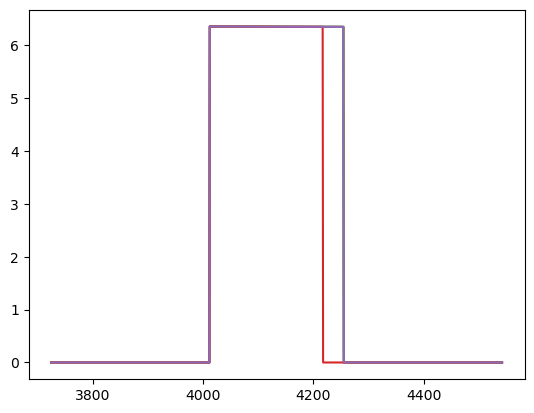

In [9]:
for skewer in skewers[:5]:
#    plt.plot(wave_fft_grid,skewer['delta_fft_grid']*mask_fft_grid)
    plt.plot(wave_fft_grid,skewer['weight_fft_grid'])

Get rid of skewers with very little data in the redshift bin

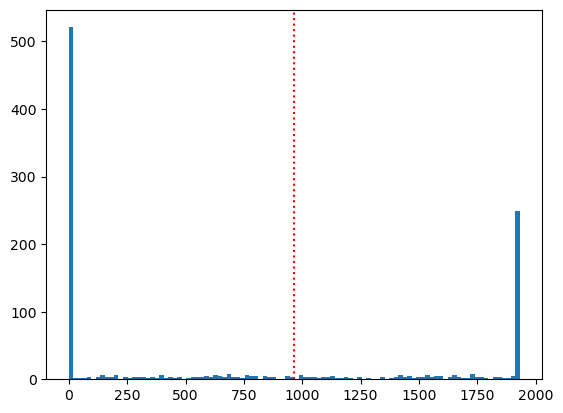

In [10]:
sumw=[np.sum(sk['weight_fft_grid']) for sk in skewers]
min_sumw=0.5*np.max(sumw)
_=plt.hist(sumw,bins=100)
plt.axvline(x=min_sumw,ls=':',color='red')

### Measure P1D from the skewers in the HEALPix pixel

In [11]:
# measure P1D and variance ( F_m = < |f_m|^2 >)
F_m=np.zeros(N_fft)
var_F_m=np.zeros(N_fft)
# mean of |w_m|^2 (FFT of mask, squared)
w2_m=np.zeros(N_fft)

In [12]:
for skewer in tqdm(skewers):
    weights=skewer['weight_fft_grid']
    deltas=skewer['delta_fft_grid']

    # FFT of mask
    w_m = np.fft.fft(weights)
    w2_m += abs(w_m)**2
    # FFT the product of deltas and weights
    f_m=np.fft.fft(deltas*weights)
    # dimensionless P1D
    p1d = abs(f_m)**2
    F_m += p1d
    var_F_m += p1d**2

100%|██████████| 1093/1093 [00:00<00:00, 33994.84it/s]


In [13]:
Nsk=len(skewers)
# normalize mask
w2_m /= Nsk
# normalize them
F_m /= Nsk
var_F_m /= Nsk
var_F_m -= F_m**2
# correct normalisation based on my notes
mean_p1d = (pw_A/N_fft) * F_m
err_p1d = (pw_A/N_fft) * np.sqrt(var_F_m/Nsk)

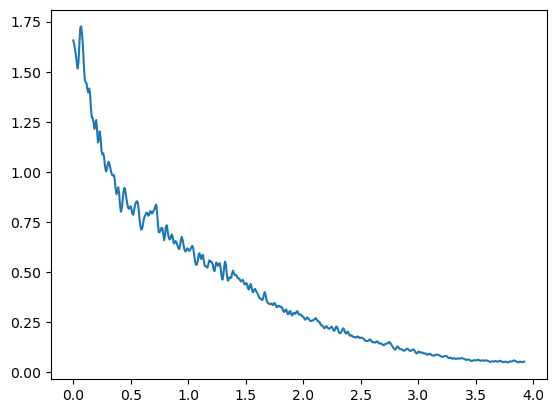

In [14]:
k_A = np.fft.fftfreq(N_fft)*2*np.pi/pw_A
plt.plot(k_A[:N_fft//2], mean_p1d[:N_fft//2])

### Measure PX from the skewers in the HEALPix pixel, averaged over a range of angular separations

In [15]:
def angular_separation(ra1, dec1, ra2, dec2):
    # Calculate the difference in right ascension
    delta_ra = ra2 - ra1
    
    # Apply the formula for angular separation
    angular_distance = np.arccos(np.sin(dec1) * np.sin(dec2) +
                                 np.cos(dec1) * np.cos(dec2) * np.cos(delta_ra))
    
    return angular_distance

In [16]:
# minimum and maximum separation, in degrees
ang_min_deg=0.2
ang_max_deg=0.4
# in radians below
ang_min=ang_min_deg*np.pi/180
ang_max=ang_max_deg*np.pi/180
print(ang_min,'< ang <',ang_max)

# measure PX 
F_m=np.zeros(N_fft)
# mean of |w_m|^2 (FFT of mask, squared)
# for PX this is (w_m v_m^*).real (product of FFT mask, real part only)
w2_m=np.zeros(N_fft)

# number of pairs
Np=0

for i1 in tqdm(range(1,Nsk)):
    sk1=skewers[i1]
    w1=sk1['weight_fft_grid']
    d1=sk1['delta_fft_grid']
    # get rid of skewers with little coverage
    if np.sum(w1)<min_sumw:
        continue
    for i2 in range(i1):
        sk2=skewers[i2]
        
        # compute angular separation, in radians
        ang=angular_separation(sk1['RA'],sk1['Dec'],sk2['RA'],sk2['Dec'])
        if ang<ang_min or ang>ang_max:
            continue

        # correlate Fourier modes
        w2=sk2['weight_fft_grid']
        d2=sk2['delta_fft_grid']
        if np.sum(w2)<min_sumw:
            continue

        Np+=1
        
        # FFT of masks
        w_1_m = np.fft.fft(w1)
        w_2_m = np.fft.fft(w2)
        w2_m += (w_1_m*np.conjugate(w_2_m)).real
 
        # and FFT again to obtain masked modes
        f_1_m=np.fft.fft(d1*w1)
        f_2_m=np.fft.fft(d2*w2)
        px = (f_1_m*np.conjugate(f_2_m)).real
        F_m += px

print('Np =',Np)
# normalize
F_m /= w2_m
# correct normalisation based on my notes
mean_px = (pw_A/N_fft) * F_m

0.003490658503988659 < ang < 0.006981317007977318


100%|██████████| 1092/1092 [00:00<00:00, 1561.09it/s]

Np = 2007


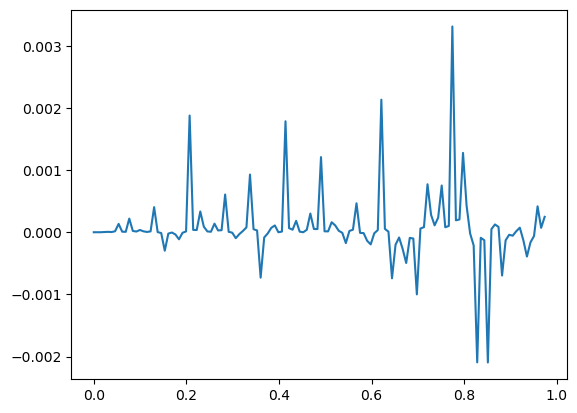

In [17]:
plt.plot(k_A[:N_fft//8], mean_px[:N_fft//8])